In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from numpy import datetime64
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import ttest_ind, ttest_ind_from_stats

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).scalar()
recent_date

'2017-08-23'

In [10]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [11]:
# Explore data types in the columns 
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for x in columns:
    print(x["name"], x["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
last_date = recent_date
one_yr_ago_date = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=365)
first_date = one_yr_ago_date.strftime("%Y-%m-%d")
# Perform a query to retrieve the data and precipitation scores
one_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= first_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
one_year_df = pd.DataFrame(one_year, columns=["date", "prcp_score"])
# Sort the dataframe by date
one_year_df = one_year_df.sort_values(by = "date").reset_index()
# Drop off any NaN 
one_year_df = one_year_df.dropna()
one_year_df = one_year_df[['date','prcp_score']]
one_year_df = one_year_df.set_index("date")

one_year_df.head()

,prcp_score
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


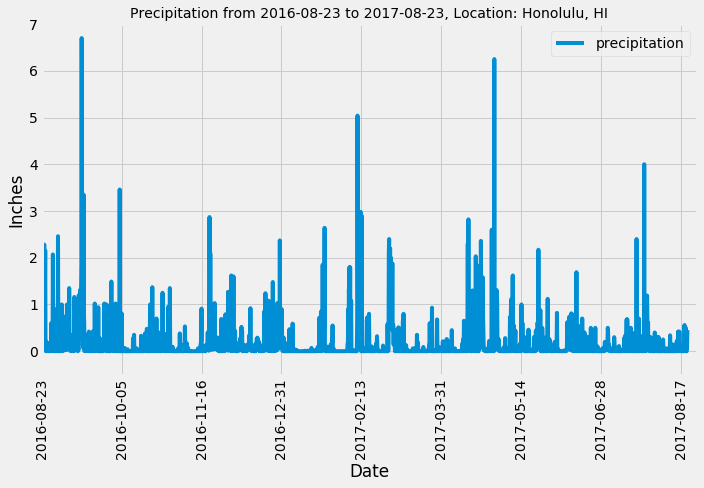

In [34]:
# Use Pandas Plotting with Matplotlib to plot the data
fig1, ax = plt.subplots(figsize=(10,7), tight_layout=True)
prcp_plot = one_year_df.plot(ax=ax)
plt.title(f"Precipitation from {first_date} to {last_date}, Location: Honolulu, HI", fontsize=14)
plt.xticks(rotation = "vertical")
plt.legend(["precipitation"])
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xlim(0, 2050)
plt.ylim(-0.5, 7)
plt.tight_layout()
plt.savefig("output/figures/honolulu_prcp.png")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stat = one_year_df.prcp_score.describe()
summary_stat

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp_score, dtype: float64

# Exploratory Station Analysis

In [15]:
columns = inspector.get_columns("station")
for x in columns:
    print(x["name"], x["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station.station).\
                group_by(Station.station).count()
print(f"Total number of stations is: {station_count}")

Total number of stations is: 9


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_act = [session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()]

print(f"The most active station is: {station_act[0][0]}")

The most active station is: USC00519281


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_temp = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                filter(Measurement.station == station_act[0][0]).all()
station_temp_df = pd.DataFrame(station_temp, columns=["lowest_temp", "highest_temp", "average_temp"])
station_temp_df

,lowest_temp,highest_temp,average_temp
0,54.0,85.0,71.663781


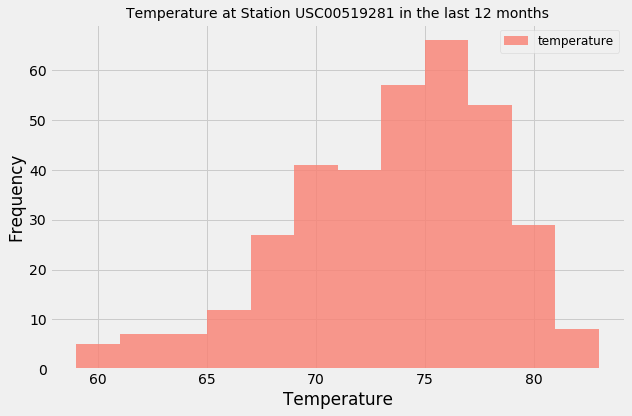

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_81 = session.query(Measurement.tobs).\
            filter(Measurement.date <= last_date, Measurement.date >= first_date,
                    Measurement.station == station_act[0][0]).all()
plt.figure(figsize=(9,6))
plt.hist(np.ravel(station_81), bins=12, color="salmon", alpha=0.8)
plt.title(f"Temperature at Station {station_act[0][0]} in the last 12 months", fontsize=14)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["temperature"], fontsize=12)
plt.tight_layout()
plt.savefig("output/figures/temp_station_81.png")
plt.show()

# Close session

In [20]:
# Close Session
session.close()